<h1 align='center'><b>Машинное обучение в бизнесе<b></h1>

<h1 align='left'>Урок 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях</h1>

<h2 align='center'>Домашняя работа</h2>

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, precision_recall_curve

# Visual libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('seaborn')

import shap

# load JS visualization code to notebook
shap.initjs()

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [3]:
df = pd.read_csv('./data/churn_data.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


### 2. сделать обзорный анализ выбранного датасета

In [4]:
df.shape

(10000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Есть как категориальные, так и вещественные признаки

Пропуски в данных отсутствуют

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


Обзор уникальных значений в признаках

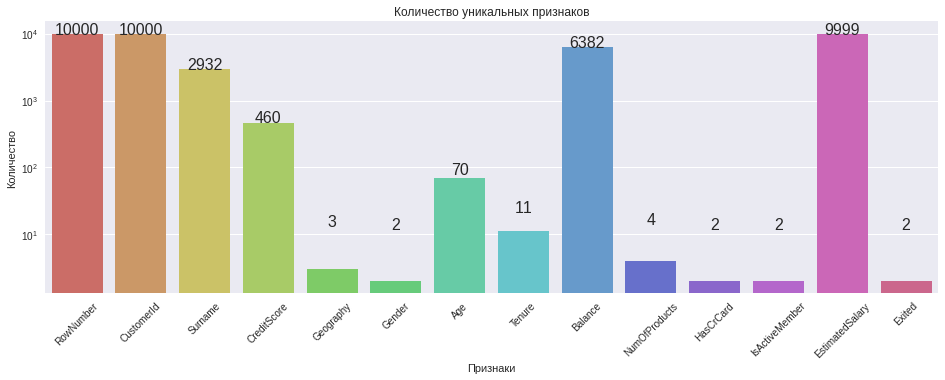

In [7]:
plt.figure(figsize=(16, 5))

cols = df.columns
uniques = [len(df[col].unique()) for col in cols]

ax = sns.barplot(x=cols, y=uniques, palette='hls', log=True)
ax.set(xlabel='Признаки', ylabel='Количество', title='Количество уникальных признаков')


for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x() + p.get_width()/2.,
            uniq + 10,
            uniq,
            ha="center") 

ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [8]:
def get_unique(df):
    columns = df.columns.tolist()
    for col in columns:
        print(f'{col}:')
        print(df[col].value_counts())
        print('='*30)

get_unique(df)

RowNumber:
1        1
6671     1
6664     1
6665     1
6666     1
        ..
3334     1
3335     1
3336     1
3337     1
10000    1
Name: RowNumber, Length: 10000, dtype: int64
CustomerId:
15634602    1
15667932    1
15766185    1
15667632    1
15599024    1
           ..
15599078    1
15702300    1
15660735    1
15671390    1
15628319    1
Name: CustomerId, Length: 10000, dtype: int64
Surname:
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: Surname, Length: 2932, dtype: int64
CreditScore:
850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: CreditScore, Length: 460, dtype: int64
Geography:
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
Gender:
Male      5457
Female    4543
Name: Gender, dtype: int64
Age:
37    478
38    477
35    474
36    456
34    447
     ..

Таким образом, у нас в основном есть категориальные переменные 
(IsActiveMember, HasCrCard, NumOfProducts, Tenure, Age, Gender, Geography, CreditScore, Surname) и 4 непрерывных: RowNumber, CreditScore, Balance, EstimatedSalary.  
Критерий CustomerId (Пользовательский ИД) не несёт смысловой нагрузки и может быть удалён.

In [9]:
df.columns.tolist()

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [10]:
TARGET_NAME = 'Exited'
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember', 'Surname', 'NumOfProducts']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

array([[<AxesSubplot:title={'center':'CreditScore'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Balance'}>,
        <AxesSubplot:title={'center':'EstimatedSalary'}>]], dtype=object)

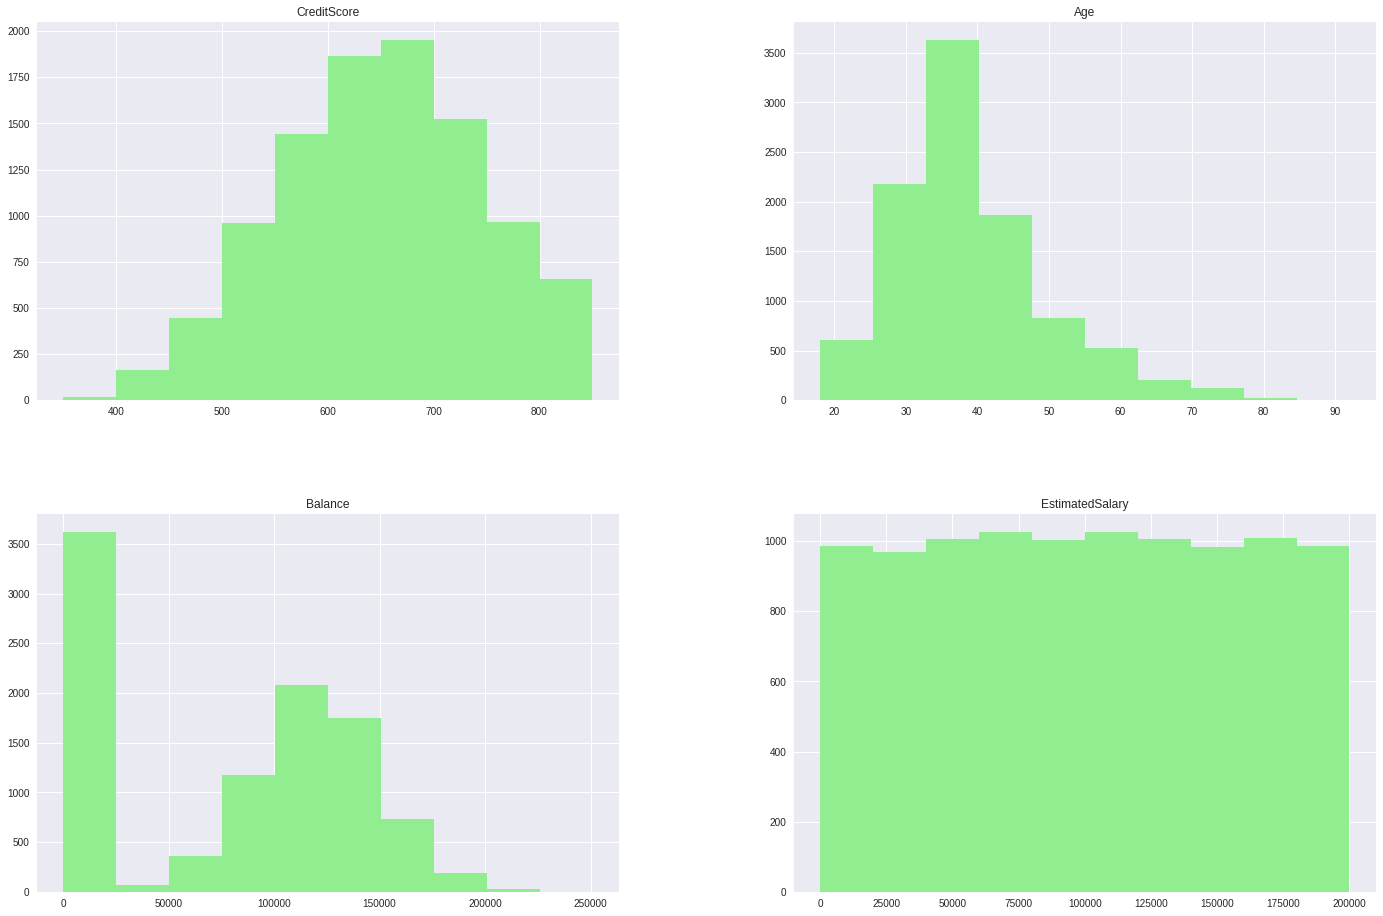

In [11]:
df[continuous_columns].hist(figsize=(24,16), color='lightgreen')

Посмотрим на распределение признаков, относитьельно целевой переменной

Geography: 
 ['France' 'Spain' 'Germany'] 



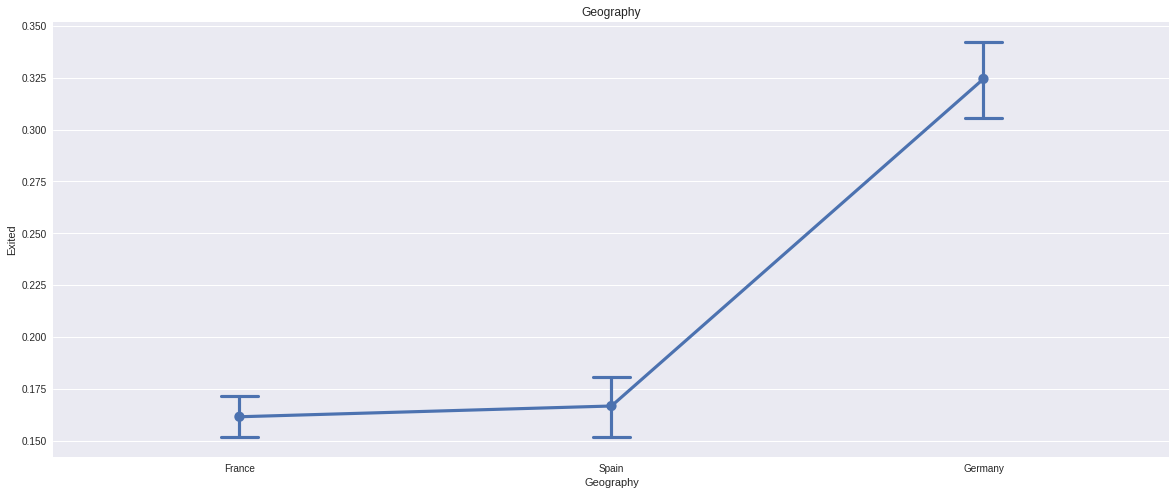

Gender: 
 ['Female' 'Male'] 



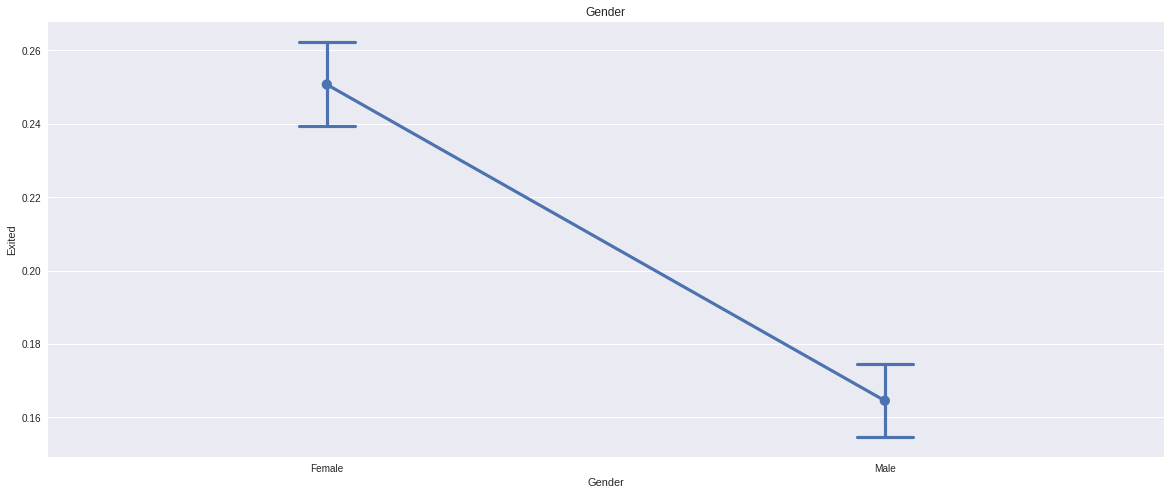

Tenure: 
 [ 2  1  8  7  4  6  3 10  5  9  0] 



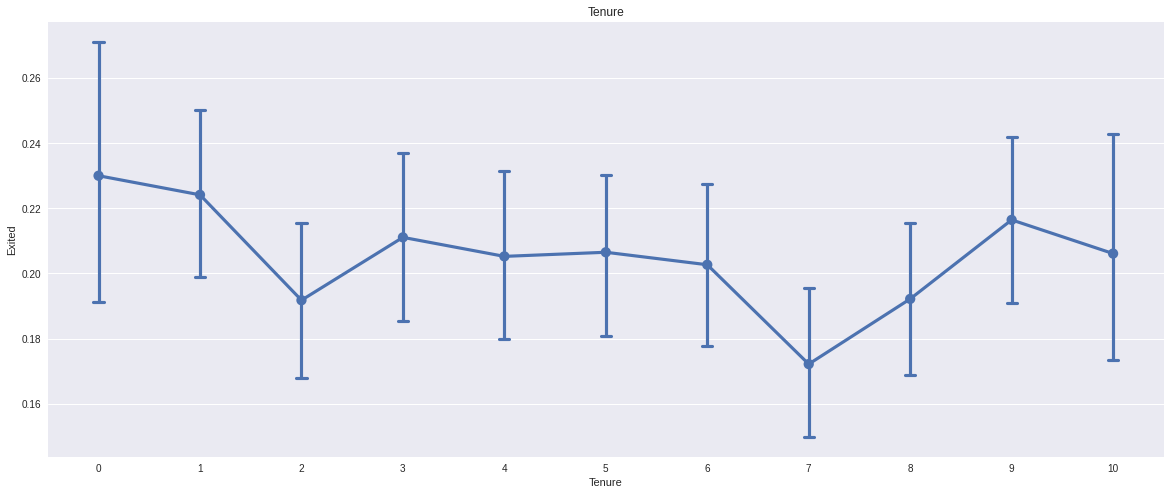

HasCrCard: 
 [1 0] 



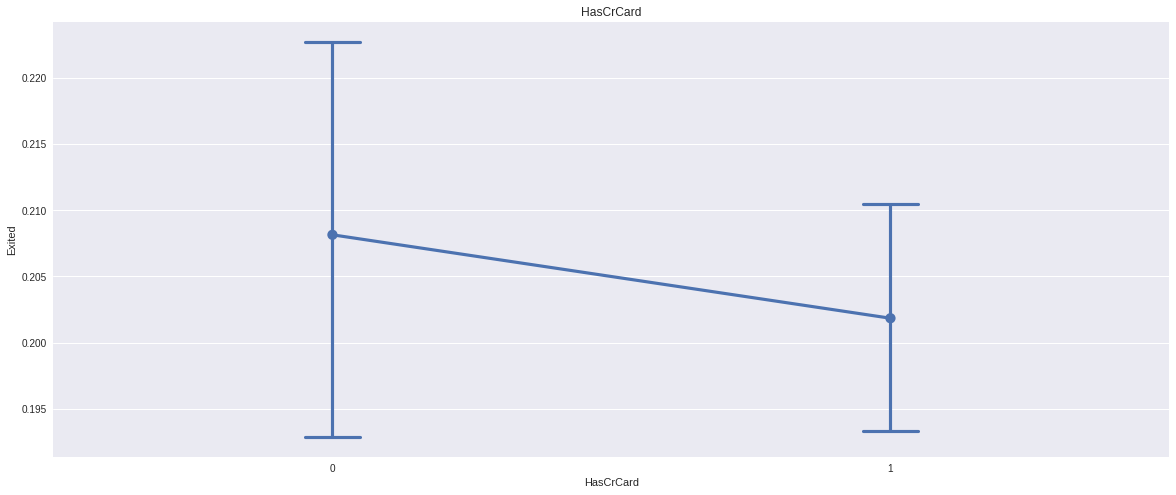

IsActiveMember: 
 [1 0] 



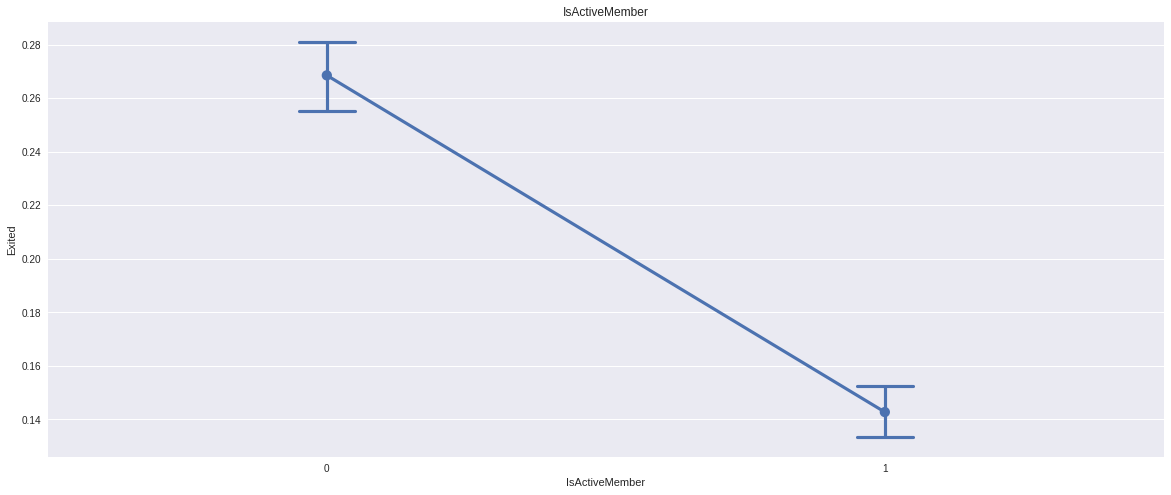

Surname: 
 ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge'] 



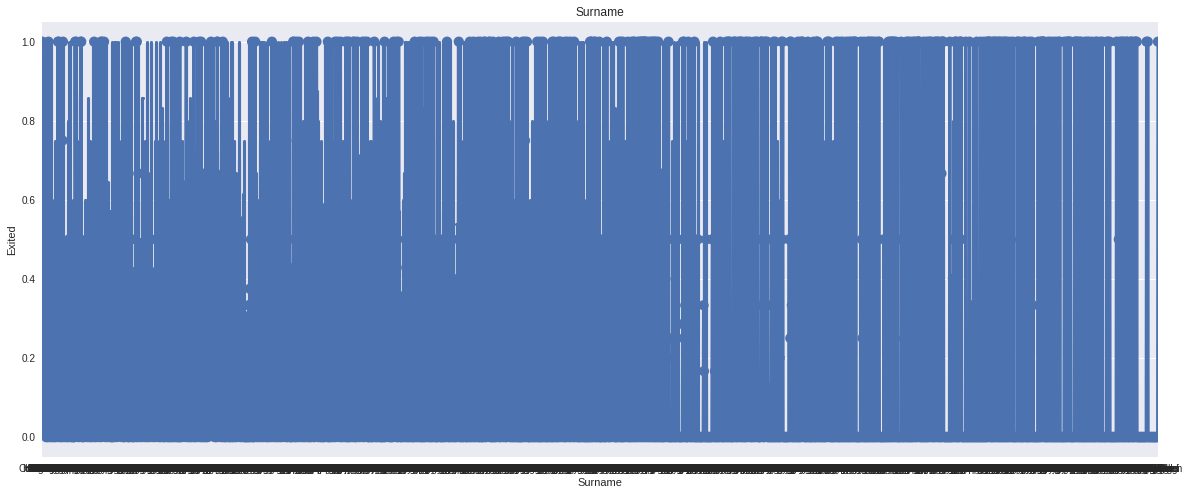

NumOfProducts: 
 [1 3 2 4] 



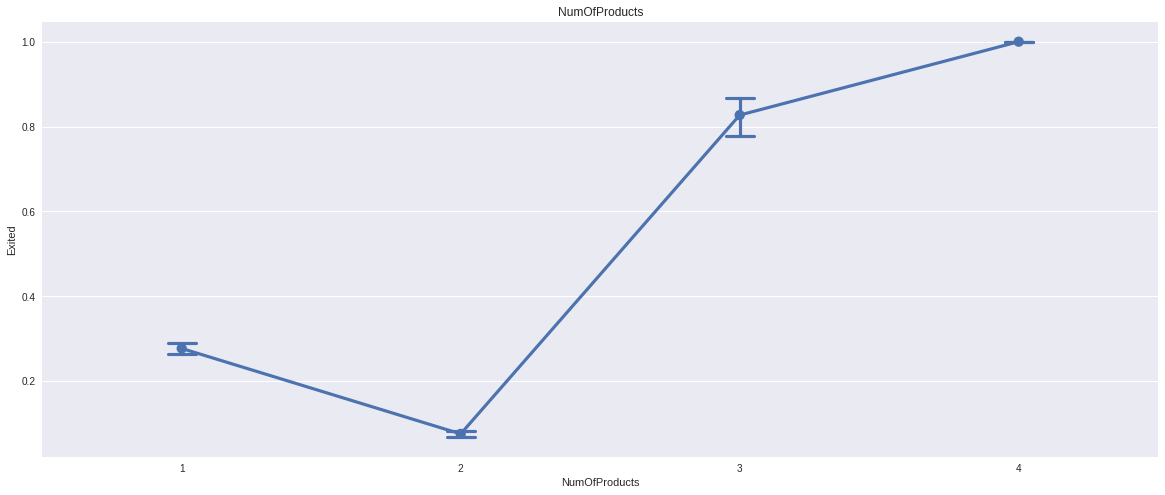

CPU times: user 41.9 s, sys: 1.27 s, total: 43.2 s
Wall time: 43.2 s


In [12]:
%%time 

for col in categorical_columns:
    x = df[col].unique()
    print(f'{col}: \n {x} \n')
    plt.figure(figsize=(20, 8))    
    sns.pointplot(x=col, y=TARGET_NAME, data=df, capsize=.1)
    plt.title(col)
    plt.show()

__ВЫВОД:__  
Проанализировав графики, можно заметить закономерности:
- Жители Германии чаще уходят в отток, а жители Франции и Испании нет;
- Женщины чаще уходят в отток, чем мужчины;
- Чаще уходят в отток неактивные пользователи;
- Пользователи с Количеством продуктов (NumOfProducts) 4 поголовно уходят в отток

Таким образом, если суммировать. Типичный пользователь, который уходит в отток — это женщина, проживающая в Германии, неактивный клиент банка и имеющая 4 продукта.

Корреляционная матрица

<AxesSubplot:>

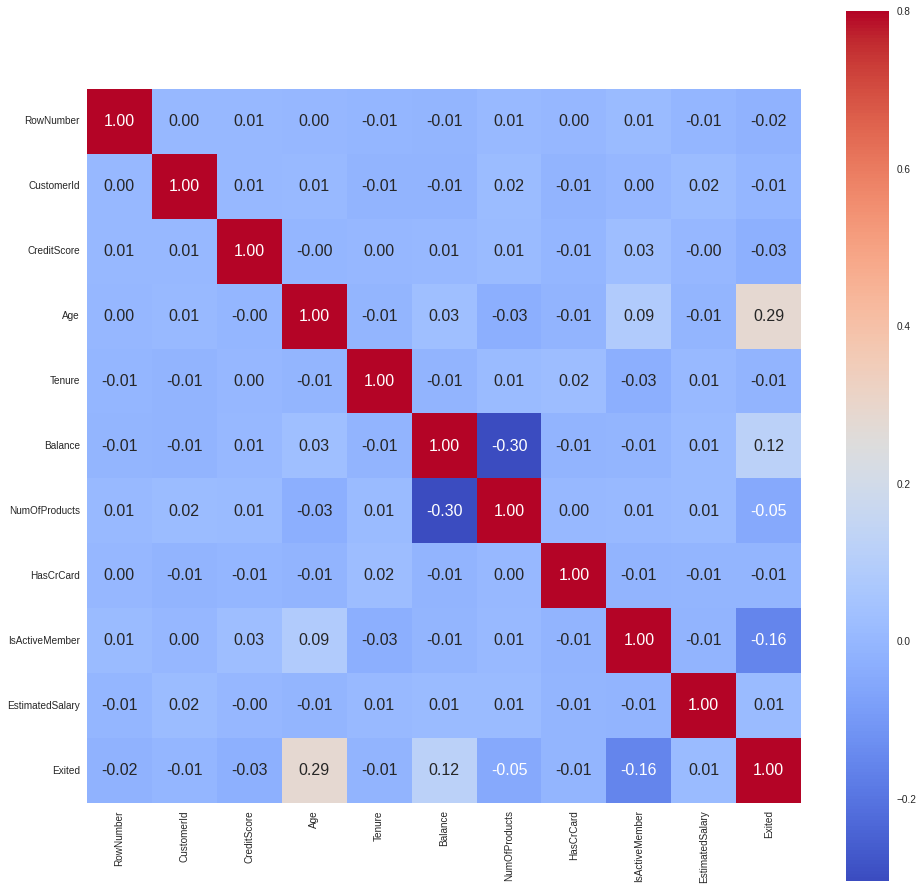

In [13]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corrmat, vmax=.8, annot=True, fmt='.2f', cmap='coolwarm', square=True)

Обзор целевой переменной

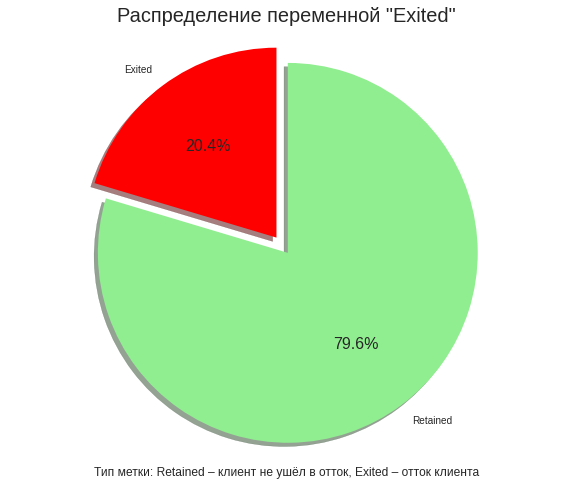

In [14]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['red', 'lightgreen'])
ax1.axis('equal')
plt.title('Распределение переменной "Exited"', size = 20)
plt.xlabel('Тип метки: Retained – клиент не ушёл в отток, Exited – отток клиента', size = 12)
plt.show()

In [15]:
is_0 = len(df[df['Exited'] == 0])
is_1 = len(df[df['Exited'] == 1])

is_0_percent = is_0 / len(df) * 100
is_1_percent = is_1 / len(df) * 100
print(f'Количество значений "0" в датасете: {is_0_percent:.3f} %')
print(f'Количество значений "1" в датасете: {is_1_percent:.3f} %')

Количество значений "0" в датасете: 79.630 %
Количество значений "1" в датасете: 20.370 %


__ВЫВОД:__   
Распределеине целевой переменной неравномерное, перевес значений 0 примерно в 4 раза. 

### 2. сделать feature engineering

Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить.  
Также удалим поля Surname и RowNumber, как не несущие никакой смысловой нагрузки.  
Категориальные признаки закодируем с помощью OneHotEncoding.  
Вещественные обработаем c помощью StandardScaler.  

In [16]:
df = df.drop(['CustomerId', 'Surname', 'RowNumber'], axis=1)

Зададим списки признаков

In [17]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [18]:
one_hot = pd.get_dummies(df[categorical_columns])
df = df.drop(categorical_columns, axis=1)
df = df.join(one_hot)

In [19]:
scaler = StandardScaler()

df_norm = df.copy()
df[continuous_columns] = scaler.fit_transform(df_norm[continuous_columns])

In [20]:
df.head()

,CreditScore,Age,Balance,EstimatedSalary,Exited,Tenure,HasCrCard,IsActiveMember,NumOfProducts,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.326221,0.293517,-1.225848,0.021886,1,2,1,1,1,1,0,0,1,0
1,-0.440036,0.198164,0.117350,0.216534,0,1,0,1,1,0,0,1,1,0
2,-1.536794,0.293517,1.333053,0.240687,1,8,1,0,3,1,0,0,1,0
3,0.501521,0.007457,-1.225848,-0.108918,0,1,0,0,2,1,0,0,1,0
4,2.063884,0.388871,0.785728,-0.365276,0,2,1,1,1,0,0,1,1,0


In [21]:
df.shape

(10000, 14)

### 3. обучить любой классификатор (какой вам нравится)

In [22]:
x_data = df.drop(['Exited'], axis=1)
y_data = df['Exited']

In [23]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state=0)

В качестве классификатора воспользуемся __RandomForestClassifier__

In [24]:
model = GradientBoostingClassifier(random_state=42)

model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

Проверяем качество

In [25]:
#наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.30321873, 0.2342115 , 0.2008756 , 0.09095795, 0.05148111,
       0.79380515, 0.0386587 , 0.04783616, 0.29397241, 0.71651386])

In [26]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test, preds)
roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, Precision=%.3f, Recall=%.3f, Roc_Auc=%.3f, F-Score=%.3f' % (thresholds[ix],
                                                                                      precision[ix],
                                                                                      recall[ix],
                                                                                      roc_auc,
                                                                                      fscore[ix]))

Best Threshold=0.329990, Precision=0.632, Recall=0.660, Roc_Auc=0.875, F-Score=0.646


Best Threshold=0.420000, Precision=0.683, Recall=0.597, Roc_Auc=0.863, F-Score=0.637

### 4. Разобраться с SHAP и построить важности признаков для: всего тестового набора данных (summary_plot - дать интерпретацию) и для топ 10%

In [28]:
%%time

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

CPU times: user 110 ms, sys: 65 µs, total: 110 ms
Wall time: 109 ms


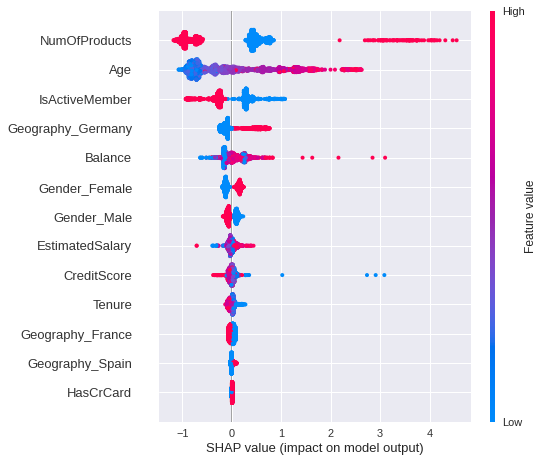

In [29]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type='dot')

__Интерпритация:__
Чем краснее цвет, тем влияние признака выше. 
NumOfProducts, IsActiveMember, Gender_Male, CreditScore, Tenure с их увеличением смещает предсказания в положительную сторону. 
Age, Geography_Germany, HasCrCard, Balance, Gender_Famale, EstimatedSalary м смещает предсказания в отрицательную сторону. 

Для топ 10

In [33]:
n = X_test.shape[1]

top_10 = round((n*10)/100)
top_10

1

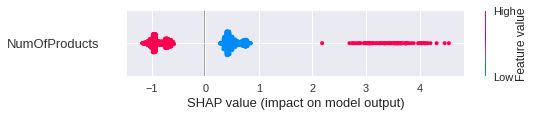

In [34]:
shap.summary_plot(shap_values, X_test, max_display = top_10)

### 5. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [35]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[42,:],  X_test.iloc[42,:])

__Интерпритация:__  
Из графика shap.force_plot для 42 объекта можно сделать вывод, что фичи Gender, NumOfProducts Age смещают наше предсказание в положительную сторону, а IsActiveMember, Geography_Germany, Balance и EstimatedSalary наоборот в отрицательную. И их влия ние оказывается сильнее - итоговое значение -0,77.